In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

### Загрузка данных

Поскольку нам больше интересно проверить, как классификаторы изображений черного ящика могут быть объяснены с помощью LIME, мы сосредоточимся только на части вывода. Давайте загрузим любые общие данные изображения. Для этого примера мы возьмем данные из этого источника: https://i.imgur.com/1Phh6hv.jpeg

458011/458011 [==============================] - 1s 2us/step


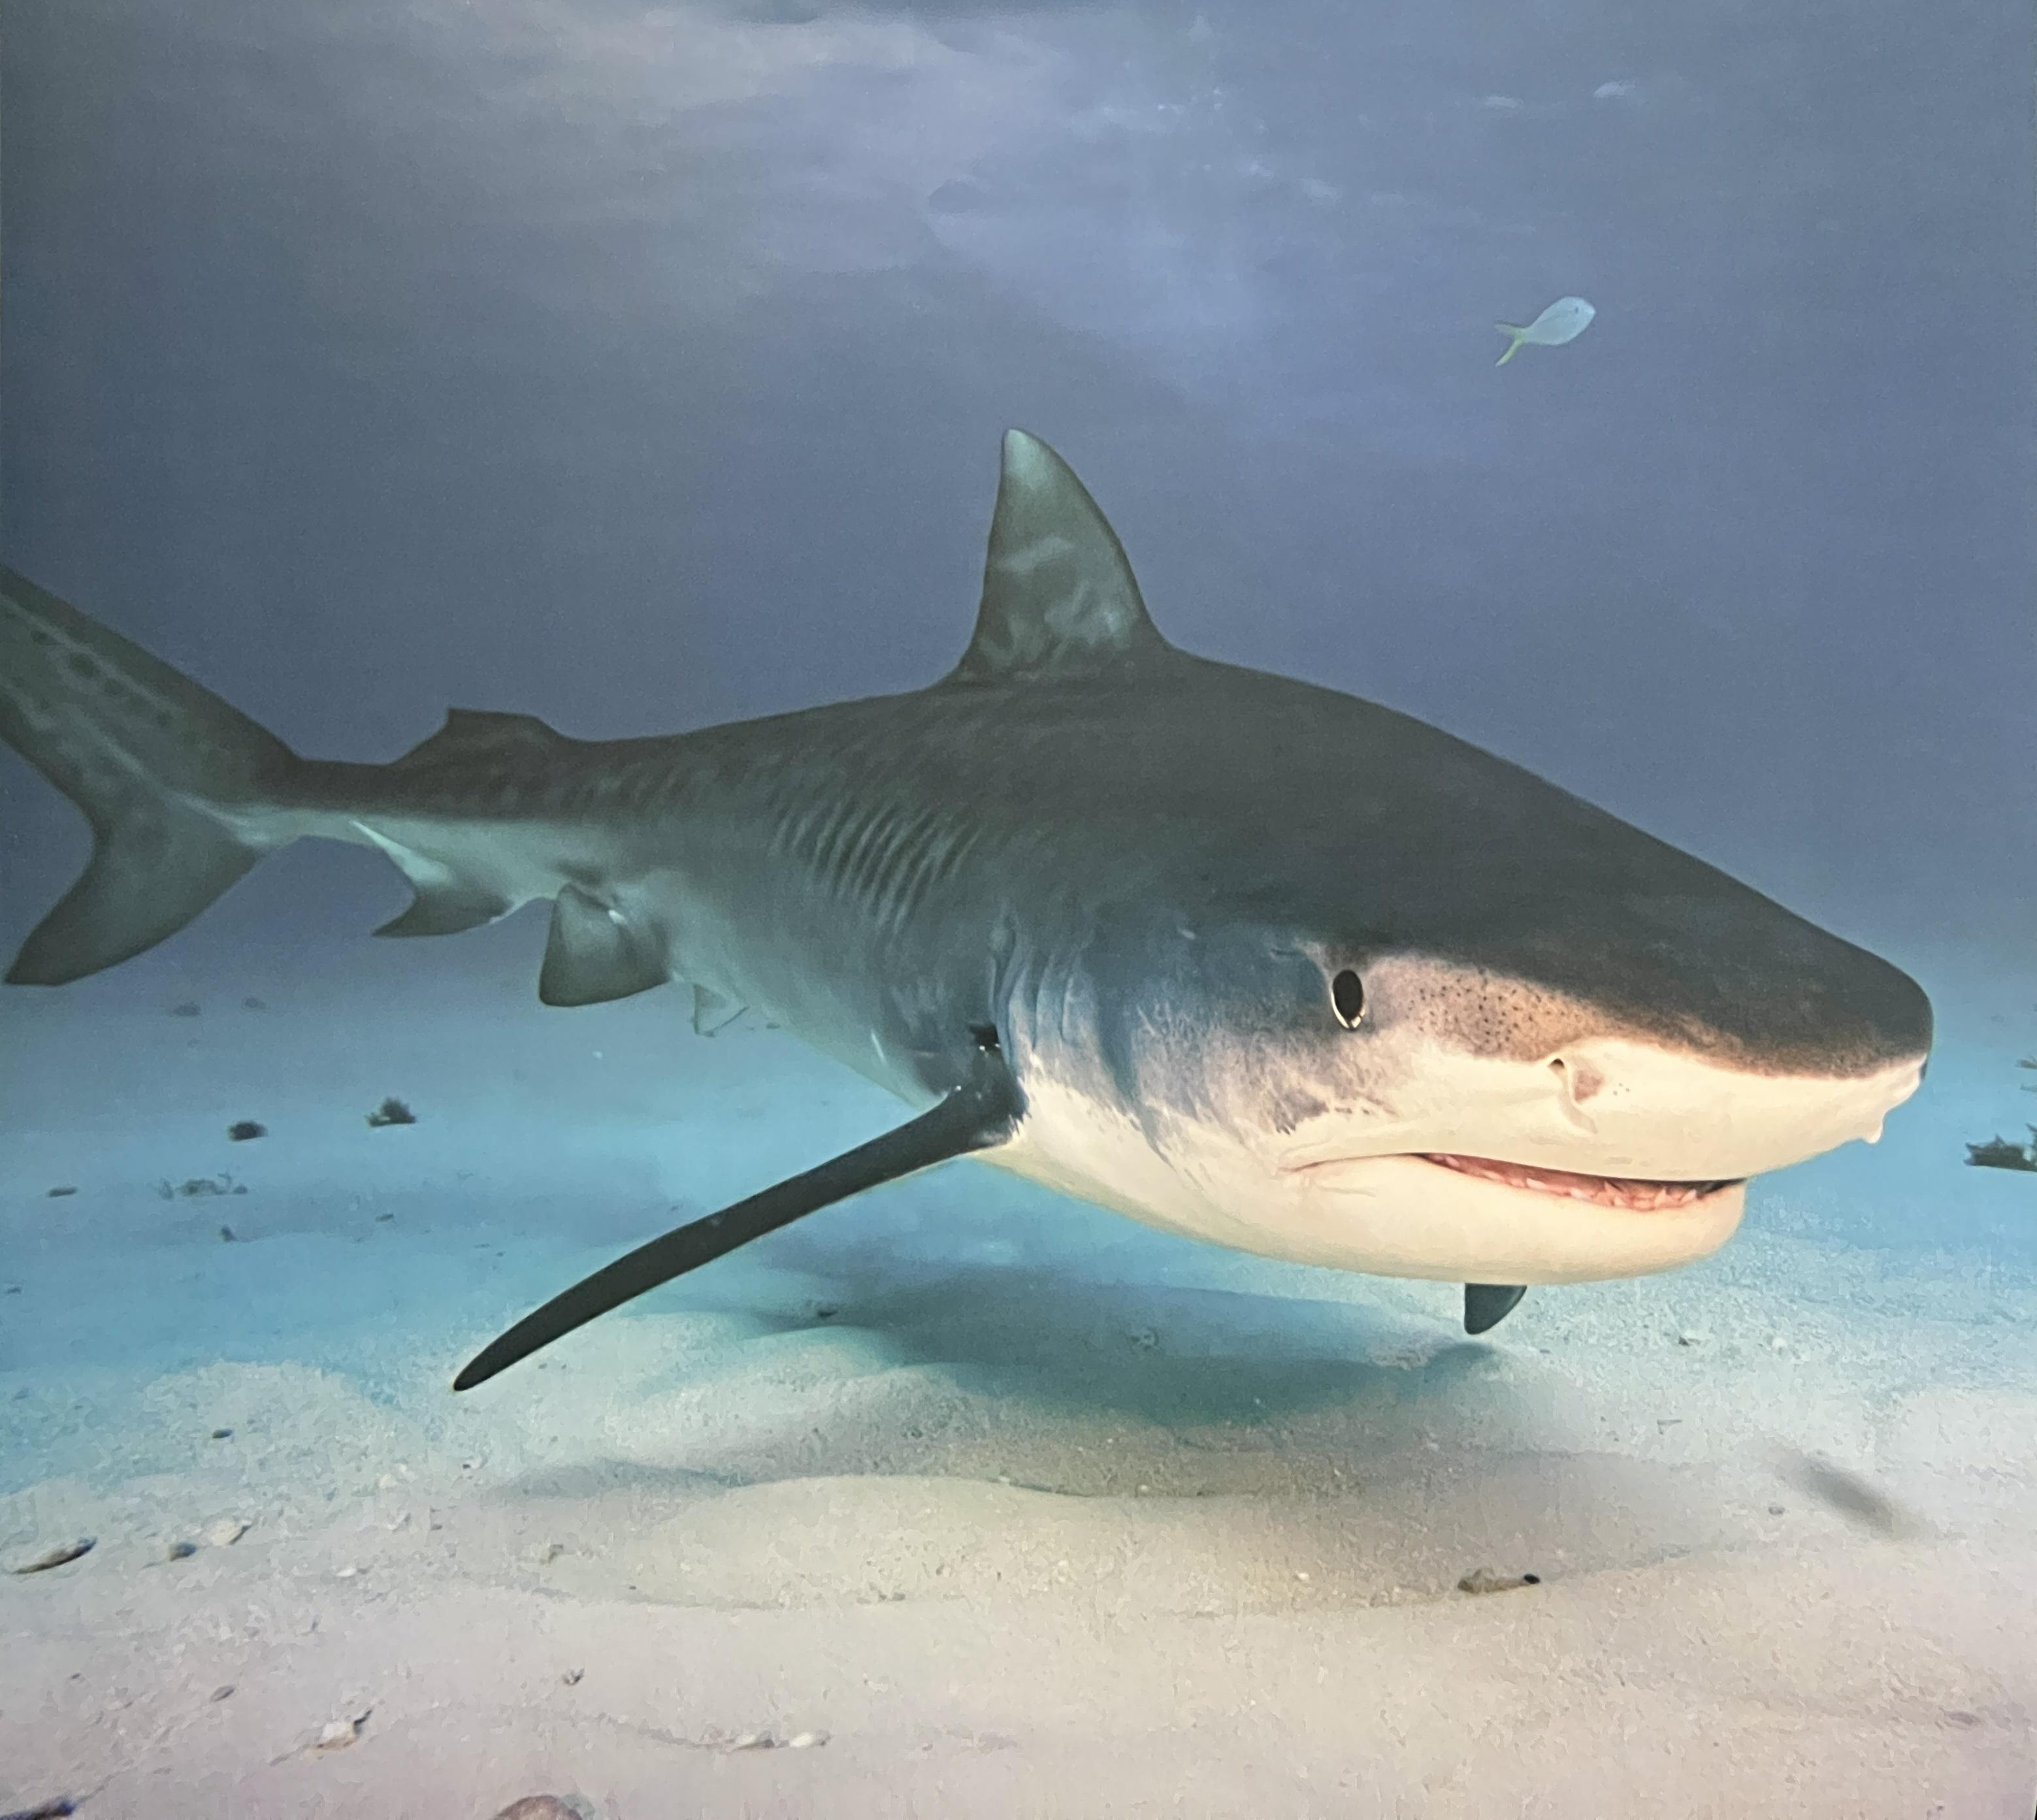

In [2]:
def load_image_data_from_url(url):
    '''
    Function to load image data from online
    '''
    # The local path to our target image
    image_path = keras.utils.get_file(
    "shark.jpg", url
    )

    display(Image(image_path))
    return image_path

image_path = load_image_data_from_url(url = "https://i.imgur.com/1Phh6hv.jpeg")

Аналогично другим учебным пособиям, описанным в этой главе, где используются классификаторы изображений. Мы выполним некоторую предварительную обработку исходных данных с помощью изображений.

In [3]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

Определение модели

В этом примере мы не обучаем модель с нуля, а скорее определяем предварительно обученную модель Tensorflow Xception в качестве нашей модели глубокого обучения черного ящика, которую мы будем объяснять с использованием фреймворка LIME.

35363/35363 [==============================] - 0s 3us/step
The predicted class is : tiger_shark


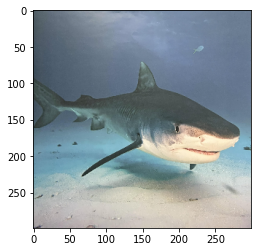

In [6]:
model = Xception(weights="imagenet")

def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]

plt.imshow(normalized_img[0])
pred_orig = get_model_predictions(normalized_img)

Изображение прогнозируется как Тигровая акула, что является правильным прогнозом, и модель черного ящика успешно может дать правильный прогноз. Теперь давайте даже взглянем на топ-5 прогнозов вместе с доверительными данными модели.


In [7]:
model_prediction = model.predict(normalized_img)
top5_pred = decode_predictions(model_prediction, top=5)[0]
for pred in top5_pred:
    print(pred[1])

1/1 [==============================] - 3s 3s/step
tiger_shark
great_white_shark
hammerhead
scuba_diver
sturgeon


Как мы видим, хотя модель хорошо обучена для получения правильного прогноза, но есть вероятность, что модель рассматривает не только основной объект на изображении, но и окружающий фон. Это видно из прогноза scuba_driver, присутствующего в списке прогнозов top 5. Итак, для нас важно понять, какие ключевые компоненты или части изображения изучает модель, чтобы сделать прогноз.

Объяснение модели с помощью ЛАЙМА

Теперь мы будем использовать фреймворк LIME для определения "суперпикселей" или сегментов изображения, используемых моделью для прогнозирования результата.

In [8]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
exp = explainer.explain_instance(normalized_img[0], 
                                 model.predict, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 20s 20s/step


Наш объект объяснения готов, но давайте визуализируем различные сегменты объяснения, созданные алгоритмом LIME.

In [ ]:
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

Теперь давайте используем верхние сегменты или суперпиксели, чтобы определить интересующую область изображения, используемого моделью для прогнозирования.

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

In [ ]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

Как мы можем видеть из приведенного выше изображения, модель смогла идентифицировать правильную область, что указывает на правильное предсказание результата моделью.


In [ ]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

In [ ]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

Приведенные выше примеры показывают нам, как мы можем скрыть или показать фон вместе с суперпикселями или даже выделить или выделить суперпиксели, чтобы определить интересующую область, используемую моделью для прогнозирования. То, что мы видим отсюда, действительно имеет смысл и позволяет нам повысить доверие к моделям черного ящика. Мы также можем сформировать тепловую карту, чтобы показать, насколько важен каждый суперпиксель, чтобы получить более детальное объяснение.

In [ ]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

Мы можем четко определить наиболее влиятельные сегменты, используемые моделью для прогнозирования, используя эту визуализацию тепловой карты.

Теперь давайте попробуем выполнить те же действия для другого класса объяснений и посмотрим, отличаются ли результаты.

In [ ]:
index = 2
print(f"We will deal with predicted class: {top5_pred[index][1]}")

In [ ]:
generate_prediction_sample(exp, exp.top_labels[index], weight = 0.0001, show_positive = False, hide_background = False)

In [ ]:
explanation_heatmap(exp, exp.top_labels[index])

В данном случае мы пытаемся выяснить, что заставило модель предсказать результат в виде акулы-молота. Когда мы использовали методы объяснения LIME, визуализации ясно показывают, что средняя часть акулы вместе с ее плавником положительно влияет на прогнозирование исхода как акулы-молота, но морда и передняя часть вносят отрицательный вклад в прогноз. Это вполне согласуется и с нашими человеческими знаниями. Акулы-молоты тоже являются акулами, поэтому средняя часть и плавник похожи на тигровых акул, но морда или передняя часть акул-молотов имеет форму молота, что значительно отличается от формы тигровой акулы.

Как мы ясно видели в этой тетради, как LIME можно легко использовать для объяснения классификаторов изображений. В следующий раз, когда вы будете работать над обучением моделей глубокого обучения для классификации изображений, я бы настоятельно рекомендовал вам попробовать LIME, чтобы объяснить вашу модель и выяснить, просматривает ли модель правильные области изображения, чтобы сделать окончательный прогноз!